In [1]:
import os
import torch
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from notears.nonlinear import notears_nonlinear
from notears.nonlinear import NotearsMLP
from causalnex.structure.notears import from_pandas
from networkx.drawing.nx_pydot import to_pydot
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

df = pd.read_csv("encoded_clean_data3.csv")

df = df.iloc[:, 1:-17]
df = df.apply(pd.to_numeric, errors="coerce")
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.apply(lambda col: col.fillna(col.mean()), axis=0)
df = df.dropna(axis=1, how="all")
df = df.dropna(axis=0, how="any")

In [2]:
features = [
    "physical_status", "Length", "LACE", "Comorbidity", "age", "BUN",
    "NIBP_MAP", "E_origin", "WBC", "HR", "admission_location", "insurance",
    "NIBP_DIA", "Acuity", "Hgb", "NIBP_SYS", "Glucose", "SpO2", "readmitted"
]

df_sel = df[features]

1. Common notears

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17552\921239461.py:9: DeprecationWarning: nx.nx_pydot.to_pydot depends on the pydot package, which hasknown issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  pydot_graph = to_pydot(sm)


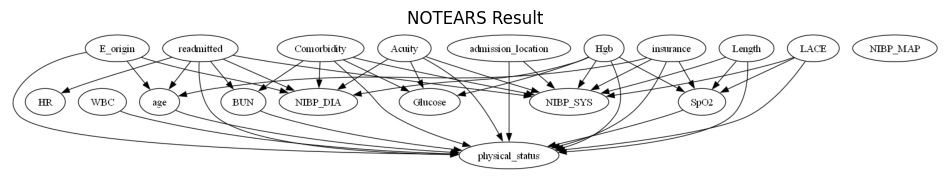

In [5]:
W_THRESHOLD = 1.5   
MAX_ITER    = 100

df_sampled = df_sel.sample(frac=0.1, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sm = from_pandas(df_sampled, w_threshold=W_THRESHOLD, max_iter=MAX_ITER)

pydot_graph = to_pydot(sm)
pydot_graph.write_png("figures/notears_result.png")

img = plt.imread("figures/notears_result.png")
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis("off")
plt.title("NOTEARS Result")
plt.show()

2. Non-linear notears

all variables

In [19]:
df0 = df.sample(frac=0.4, random_state=42)
X0 = df0.to_numpy().astype(np.float32)
columns0 = df0.columns.tolist()

d0 = X0.shape[1]
model = NotearsMLP(dims=[d0, 10, 1], bias=True)

W0 = notears_nonlinear(
    model,           
    X0,               
    lambda1=0.3,    # L1 regularization for sparsity; higher values yield fewer edges
    lambda2=0.5,    # L2 regularization for smoothness; helps prevent overfitting
    max_iter=100,    
    h_tol=1e-6,      # Tolerance for DAG constraint convergence; lower is stricter
    rho_max=1e+16,   # Maximum penalty parameter for augmented Lagrangian
    w_threshold=0.5
    )

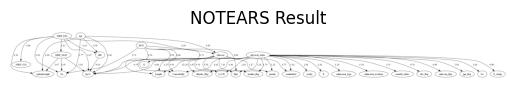

In [21]:
np.savetxt("saved_models/notears_w0.csv", W0, delimiter=",")

G = nx.DiGraph()
for i in range(len(columns0)):
    for j in range(len(columns0)):
        weight = W0[i, j]
        if i != j and abs(weight) > 0.01:
            G.add_edge(
                columns0[j],
                columns0[i],
                weight=weight,
                label=f"{weight:.2f}"                  
            )

pydot_graph = to_pydot(G)
pydot_graph.write_png("figures/nonlinear_notears.png")

img = plt.imread("figures/nonlinear_notears.png")
plt.imshow(img)
plt.axis("off")
plt.title("NOTEARS Result")
plt.show()

20 variables

In [22]:
df_sampled = df_sel.sample(frac=0.4, random_state=42)
X = df_sampled.to_numpy().astype(np.float32)
columns = df_sampled.columns.tolist()

d = X.shape[1]
model = NotearsMLP(dims=[d, 10, 1], bias=True)

W = notears_nonlinear(
    model,           
    X,               
    lambda1=0.1,    # L1 regularization for sparsity; higher values yield fewer edges
    lambda2=0.1,    # L2 regularization for smoothness; helps prevent overfitting
    max_iter=100,    
    h_tol=1e-6,      # Tolerance for DAG constraint convergence; lower is stricter
    rho_max=1e+16,   # Maximum penalty parameter for augmented Lagrangian
    w_threshold=0.4
    )

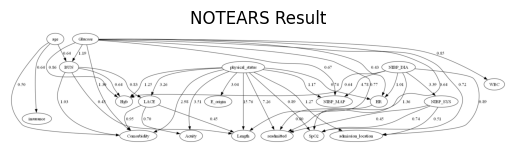

In [ ]:
np.savetxt("saved_models/notears_w.csv", W, delimiter=",")

G = nx.DiGraph()
for i in range(len(columns)):
    for j in range(len(columns)):
        weight = W[i, j]
        if i != j and abs(weight) > 0.01:
            G.add_edge(
                columns[j],
                columns[i],
                weight=weight,
                label=f"{weight:.2f}"                  
            )

pydot_graph = to_pydot(G)
pydot_graph.write_png("figures/nonlinear_notears2.png")

img = plt.imread("figures/nonlinear_notears2.png")
plt.imshow(img)
plt.axis("off")
plt.title("NOTEARS Result")
plt.show()

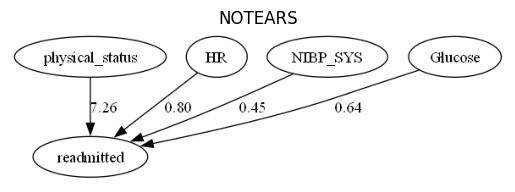

In [4]:
W = np.loadtxt("saved_models/notears_w.csv", delimiter=",")

df_sampled = df_sel.sample(frac=0.4, random_state=42)
X = df_sampled.to_numpy().astype(np.float32)
columns = df_sampled.columns.tolist()

target_node = "readmitted"

G = nx.DiGraph()
target_idx = columns.index(target_node)

for i in range(len(columns)):
    weight_in = W[target_idx, i]
    if i != target_idx and abs(weight_in) > 0.01:
        G.add_edge(columns[i], target_node, weight=weight_in, label=f"{weight_in:.2f}")
        
    weight_out = W[i, target_idx]
    if i != target_idx and abs(weight_out) > 0.01:
        G.add_edge(target_node, columns[i], weight=weight_out, label=f"{weight_out:.2f}")

pydot_graph = to_pydot(G)
pydot_graph.write_png("figures/notears_readmitted_only2.png")

img = plt.imread("figures/notears_readmitted_only2.png")
plt.imshow(img)
plt.axis("off")
plt.title("NOTEARS")
plt.show()

10 variables

In [25]:
features2 = [
    "physical_status", "Length", "LACE", "Comorbidity", "age", "BUN",
    "NIBP_MAP", "E_origin", "WBC", "readmitted"
]

df2 = df[features2]
df2 = df2.sample(frac=0.4, random_state=42)

X2 = df2.to_numpy().astype(np.float32)
columns2 = df2.columns.tolist()

d2 = X2.shape[1]
model2 = NotearsMLP(dims=[d2, 10, 1], bias=True)

W2 = notears_nonlinear(
    model2,           
    X2,               
    lambda1=0.1,    # L1 regularization for sparsity; higher values yield fewer edges
    lambda2=0.05,    # L2 regularization for smoothness; helps prevent overfitting
    max_iter=100,    
    h_tol=1e-6,      # Tolerance for DAG constraint convergence; lower is stricter
    rho_max=1e+16,   # Maximum penalty parameter for augmented Lagrangian
    w_threshold=0.5
    )

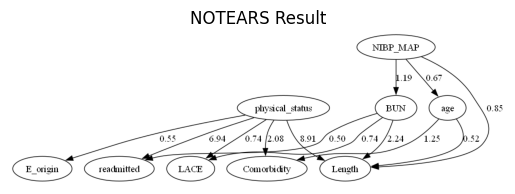

In [26]:
np.savetxt("saved_models/notears_w2.csv", W2, delimiter=",")

G = nx.DiGraph()
for i in range(len(columns2)):
    for j in range(len(columns2)):
        weight = W2[i, j]
        if i != j and abs(weight) > 0.01:
            G.add_edge(
                columns2[j],
                columns2[i],
                weight=weight,
                label=f"{weight:.2f}"                  
            )

pydot_graph = to_pydot(G)
pydot_graph.write_png("figures/nonlinear_notears3.png")

img = plt.imread("figures/nonlinear_notears3.png")
plt.imshow(img)
plt.axis("off")
plt.title("NOTEARS Result")
plt.show()

6 variables

In [28]:
features3 = [
    "physical_status", "Length", "LACE", "Comorbidity", "age", "readmitted"
]

df3 = df[features3]
df3 = df3.sample(frac=0.1, random_state=42)

X3 = df3.to_numpy().astype(np.float32)
columns3 = df3.columns.tolist()

d3 = X3.shape[1]
model3 = NotearsMLP(dims=[d3, 10, 1], bias=True)

W3 = notears_nonlinear(
    model3,           
    X3,               
    lambda1=0.05,   
    lambda2=0.01,    
    max_iter=100,    
    h_tol=1e-7,      
    rho_max=1e+16,   
    w_threshold=0.2
    )

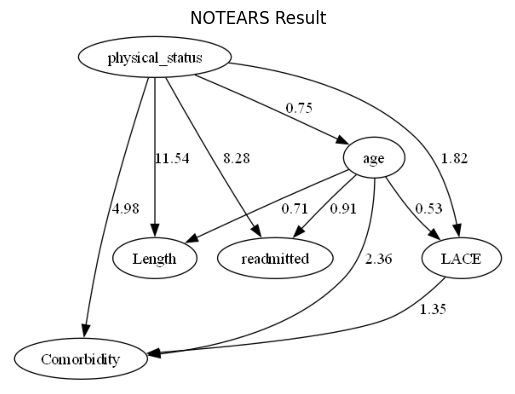

In [29]:
np.savetxt("saved_models/notears_w3.csv", W3, delimiter=",")

G = nx.DiGraph()
for i in range(len(columns3)):
    for j in range(len(columns3)):
        weight = W3[i, j]
        if i != j and abs(weight) > 0.01:
            G.add_edge(
                columns3[j],
                columns3[i],
                weight=weight,
                label=f"{weight:.2f}"                  
            )

pydot_graph = to_pydot(G)
pydot_graph.write_png("figures/nonlinear_notears4.png")

img = plt.imread("figures/nonlinear_notears4.png")
plt.imshow(img)
plt.axis("off")
plt.title("NOTEARS Result")
plt.show()

__Linear__ NOTEARS assumes that causal relationships are linear and uses a global linear Structural Equation Model (SEM);  
In contrast, __Nonlinear__ NOTEARS allows each variable to be a nonlinear and differentiable function of others. These functions are typically parameterized by multi-layer perceptrons (MLPs) or orthogonal basis expansions, enabling the discovery of more flexible and realistic causal structures beyond linear dependencies.